# Compartimentalization 

## 1-Theory
In this section, previsouly called quantities "$X_i^p$" and "$X_j^n$" are  the number of positive particle of type $i$ and negative particle of tpe $j$ in the bulk phase, whereas  "$k_i$" and "$l_j$" are the same quantities for the species $i$ and $j$ but in a droplet.

### Hypothesis and possible improvements
-We first only consider noise over entries and not over reaction, the latter would have lead us to consider Gillespi simultion.

-We consider quantities of A and B to be *high enough* to consider the linearized version of our equation, i.e. the following one.


-Our previous equations were over concentrations a and b. Nevertheless, one would think in term of number of particles. Therefore, we shall have the number of particle A=aV and B=bV as a function of the characteristic volume V of a droplet. Yet, such a volume can be a random variable...
To adress more simply the problem, we first consider such volume to be constant. Then, we can write $\frac{dA}{dt} = PV + \frac{\lambda_a \cdot A }{1 + k_a/V \cdot A} - \eta_a \cdot A - \mu_a/V \cdot A B$. Provinding the rescaling $P/V\rightarrow P$, $k_a / V\rightarrow k_a$ and $\mu_a /V \rightarrow \mu_a$, one can write the stoechiometric version of the system 



$$
\frac{dA}{dt} = P + \frac{\lambda_a \cdot A}{1 + k_a \cdot A} - \eta_a \cdot A - \mu_a \cdot AB
$$
$$
\frac{dB}{dt} = N + \frac{\lambda_b \cdot B}{1 + k_b \cdot B} - \eta_b \cdot B - \mu_b \cdot AB
$$

Where:
- $A,B$: number of particles
- $P=\sum_i w_i^pk_i, N=\sum_j w_j^n l_j $: external input/production rates
- $\lambda_a, \lambda_b$: growth rate constants
- $k_a, k_b$: saturation constants (Hill-type terms)
- $\eta_a, \eta_b$: decay or dilution rates
- $\mu_a, \mu_b$: interaction strengths between $a$ and $b$

### 1.1 Joint probability
We start from a bulk phase, in which there exist two classes of species, one "positive", containing a number of particle $i$, {$X_i^p$} , which lead to the creation of $A$ and "negative" containing the number particle $X_j^n$, {$l_j$} which lead to the creation of $B$. 

We would like to obtain the probability to have in a compartment n particles (whose average is denoted as $\lambda$) with m of them from the "positive" class (so n-m of them are from the "negative" class), and with a given population vector $\vec{k}$ (encoding the number of particle of each specie $i$) and $\vec{l}$.

Therefore, $n$,$m$, $\vec{k}$, $\vec{l}$ are all realisations of the associated random variable.

We can write the joint probability
$$P_{\lambda}(n,m,\vec{k},\vec{l})=\underbrace{e^{-\lambda}\frac{\lambda^n}{n!}}_{\text{(a) Poisson nb total}} \cdot\underbrace{\frac{m!}{\prod_i k_i!}\prod_i(p_i)^{k_i}}_{\text{(c) Multinomiale $\vec{k}$|m}}\cdot \underbrace{\frac{(n-m)!}{\prod_jl_j!}\prod_j(q_j)^{l_j}}_{\text{(d) Multinomiale $\vec{l}$|n-m}} $$

with constrains $\sum_ik_i=m$ and $\sum_jl_j=n-m$

(a) Is a Poissonian distribution for n the number of particle in a compartiment. The average is $\langle n\rangle=\langle n^2\rangle-\langle n\rangle^2=\lambda=\text{Var}(n)$



(c) Is a Multinomial distribution for the repartion of the $i$-th positive inputs (whose probability is denoted $p_i=\frac{X_i^p}{\sum_iX_i^p}$) among the positive particles. We have $\sum_ip_i=1$. So this term describes the proba to obtain the population vector $\vec{k}=(k_1,k_2,...)$|m positive particles. We have $\langle k_i \rangle=mp_i$ and $\text{Var}(k_i)=mp_i(1-p_i)$

(d) Is a Multinomial distribution for the repartion of the $j$-th negative inputs (whose probability is denoted $q_j=\frac{X_j^n}{\sum_jX_j^n}$) among the negative particles. We have $\sum_jq_j=1$. So this term describes the proba to obtain the population vector $\vec{l}=(l_1,l_2,...)$|m-n negatives particles. We have $\langle l_j \rangle=(m-n)q_j$ and $\text{Var}(l_i)=(m-n)q_j(1-q_j)$.


### 1.2 Thermodynamical limit (to be forgotten)
Having ${X_i^p}$ and ${X_j^n}$ the initial number of species in the bulk, we denote the number of such inputs in a droplet as $k_i$ and $l_i$, both being random variables.


When both $\langle k_i \rangle>>1$ and $\langle l_j \rangle>>1$ 

Then, the joint proba is given by 
$$f(c_p, c_n) = 
\prod_{i=1}^{N} \left( \frac{1}{\sqrt{2\pi \frac{X_i^p}{N_A V}}} 
\exp\left( -\frac{(c_i^p - X_i^p)^2}{2 \frac{X_i^p}{N_A V}} \right) \right)
\cdot
\prod_{j=1}^{N} \left( \frac{1}{\sqrt{2\pi \frac{X_j^n}{N_A V}}} 
\exp\left( -\frac{(c_j^n - X_j^n)^2}{2 \frac{X_j^n}{N_A V}} \right) \right)$$


We could rewrite this as


* $\mathbf{c}^p = (c_1^p, \dots, c_N^p)^\top$ : vecteur des concentrations des $N$ espèces **p** dans une goutte.
* $\mathbf{X}^p = (X_1^p, \dots, X_N^p)^\top$ : leurs concentrations initiales dans la solution.
* $V$ : volume de la goutte.
* Les matrices de covariance diagonales sont données par :

  $$
  \boldsymbol{\Sigma}^p = \frac{1}{ V} \, \mathrm{diag}(\mathbf{X}^p), \quad
  \boldsymbol{\Sigma}^n = \frac{1}{ V} \, \mathrm{diag}(\mathbf{X}^n)
  $$


$$
f(\mathbf{c}^p, \mathbf{c}^n) = \frac{1}{(2\pi)^N \sqrt{\det \boldsymbol{\Sigma}^p \, \det \boldsymbol{\Sigma}^n}} \,
\exp\left( -\frac{1}{2} (\mathbf{c}^p - \mathbf{X}^p)^\top (\boldsymbol{\Sigma}^p)^{-1} (\mathbf{c}^p - \mathbf{X}^p) \right)
\exp\left( -\frac{1}{2} (\mathbf{c}^n - \mathbf{X}^n)^\top (\boldsymbol{\Sigma}^n)^{-1} (\mathbf{c}^n - \mathbf{X}^n) \right)
$$


Nevertheless, this result requires high enough particle number in each compartment.

## 1.3 Compartimentalization dynamic
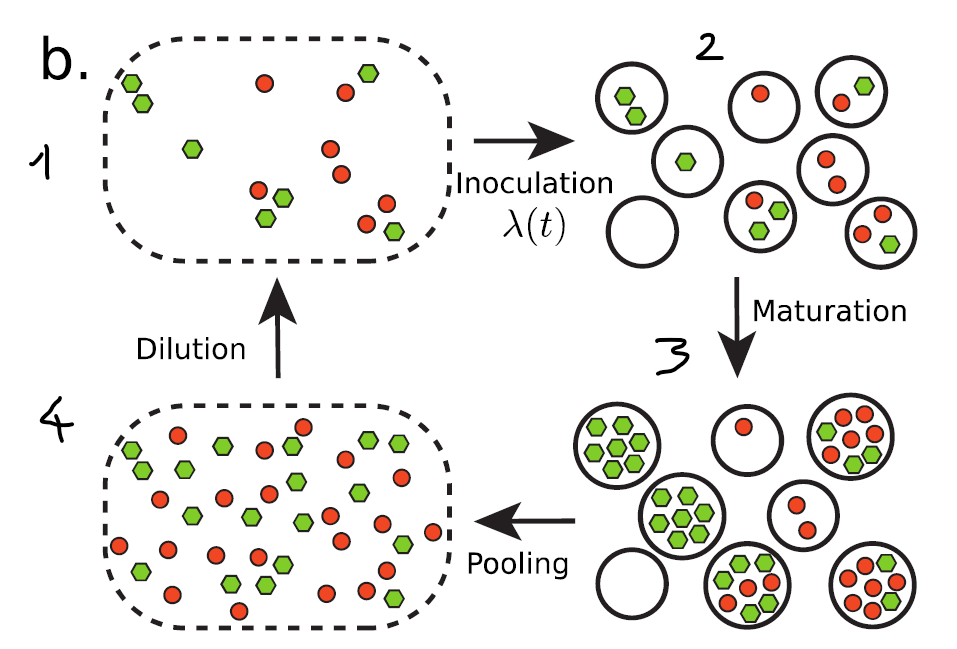


**First round**

The first round is assimilated to the first layer of the NN, whose entris are the $\vec{k}=(k_1,...,k_i,...),\vec{l}=(l_1,...,l_j,...)$ and with outputs $\vec{a}=(a_1,a_2,...a_{\mu},...),\vec{b}=(b_1,b_2,..,b_{\mu},...$ with $\mu$ indexing each neuron of the first layer. Therefore, $a_1$ is the final number of particle $a$ in the neuron 1.


(1) We have a solution of inputs of concentrations given by $\vec{k},\vec{l}$. 

(2) We compartimentalize the system in droplets. Assuming initial concentrations of inputs are high enough (which is achieved because we impose the solution to be at saturation), concentrations of inputs can be considered as distributed according to the gaussian proba density. Nevertheless, we stick to the general form $P_{\lambda}$ for simplicity.
In each droplet a ball is injected, carrying all enzymes required for the neuron reaction to happen. Such a structure (droplet containing inputs + ball) are called "neuron" and each "neuron" of this first layer is labeled by $\mu$.

(3) We let each droplet evolving until steady state of the output $(a^*,b^*)$, according to the equation $\frac{da}{dt}=...$ and $\frac{db}{dt}=...$. At the end, most of neurons will be either in full a, either in full b (a few of them shall remain in an "undecicded" state $a^*=b^*$)

(4) A dilution could be achieved, yet we do not considers such a thing for the moment

The outputs of the first layer are $\vec{a}=(a_1,a_2,...a_{\mu},...),\vec{b}=(b_1,b_2,..,b_{\mu},...)$ with $\mu$ indexing each neuron. 



**Second round**
This is the second layer of the NN. Inputs of this layers are $\vec{a},\vec{b}$.


(1) We have a solution of inputs of concentrations given by $\vec{a},\vec{b}$.

(2) We compartimentalize the system in droplets. Here, initial concentrations of inputs may not be high enough to assume that the number of input in each neuron are sufficiant to assume CLT. With $\langle k_i \rangle, \langle l_i \rangle$ being the average number of positive or negative input of species $i$ in a neuron, we have :  
 - if  $\langle k_i \rangle=V X_i^p\sim 1$ and $\langle l_j \rangle=VX_j^n\sim 1 $, then $k_i \sim Poisson(V X_i^p)$
 - if  $\langle k_i \rangle=VX_i^p>>1$ and $\langle l_j \rangle=VX_j^n>>1$, then $c_i\sim \mathcal{N}(X_i^p,X_i^p/V)$

In each droplet a ball is injected, carrying all enzymes required for the neuron reaction to happen. Such a structure (droplet containing inputs + ball) are called "neuron" and each "neuron" is labeled by $\mu$.

(3) We let each droplet evolving until steady state of the output $(a^*,b^*)$, according to the equation $\frac{da}{dt}=...$ and $\frac{db}{dt}=...$. At the end, most of neurons will be either in full a, either in full b (a few of them shall remain in an "undecicded" state $a^*=b^*$)


*Rmk*: we could also talk in term of concentration of $a$, i.e $x=\frac{\sum_{\mu}a_{\mu}}{\sum_{\mu}a_{\mu}+b_{\mu}}$

Assuming initial concentrations of inputs are high enough (which is achieved because we impose the solution to be at saturation), concentrations of inputs are distributed according to the gaussian proba density $f(\mathbf{c}^p, \mathbf{c}^n)=f(c_1^p,c_2^p,...,c_1^n,c_2^n,...)$.

## 1.1 Symmetrical system

here after pooling all output, we sum all a and b to get a_input and b_input

Simulation en cours: 100%|██████████| 400/400 [00:30<00:00, 12.93it/s]


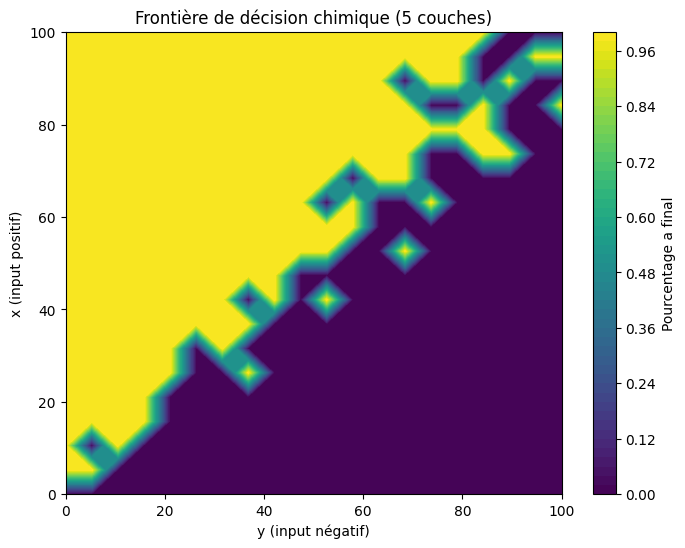

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# Paramètres globaux des équations chimiques
lambda_a = 1.0
lambda_b = 1.0
ka = 0.5
kb = 0.5
eta_a = 0.1
eta_b = 0.1
mu_ab = 0.2

# Fonction dynamique d'une gouttelette (neuron chimique)
def neuron_dynamics(t, y, x_in, y_in, w_p_x=1.0, w_p_y=1.0):
    a, b = y
    da_dt = w_p_x * x_in + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = w_p_y * y_in + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

# Fonction qui simule une couche chimique
def simulate_layer(X_bulk_vec, Y_bulk_vec, n_neurons=10):
    X_bulk = np.sum(X_bulk_vec)
    Y_bulk = np.sum(Y_bulk_vec)
    lambda_total = (X_bulk + Y_bulk) / n_neurons

    # Probabilities
    if (X_bulk + Y_bulk) > 0:
        r = X_bulk / (X_bulk + Y_bulk)
    else:
        r = 0.0

    p_vec = X_bulk_vec / X_bulk if X_bulk > 0 else np.zeros_like(X_bulk_vec)
    q_vec = Y_bulk_vec / Y_bulk if Y_bulk > 0 else np.zeros_like(Y_bulk_vec)

    a_outputs = []
    b_outputs = []

    for _ in range(n_neurons):
        # Poisson total
        n = np.random.poisson(lambda_total)

        # Binomial for positives
        m = np.random.binomial(n, r) if n > 0 else 0

        # Multinomial for positive species
        x_vec = np.random.multinomial(m, p_vec) if m > 0 else np.zeros_like(X_bulk_vec)

        # Multinomial for negative species
        y_vec = np.random.multinomial(n - m, q_vec) if (n - m) > 0 else np.zeros_like(Y_bulk_vec)

        # Total input to neuron
        x_in = np.sum(x_vec)  # could be weighted sum if species have weight
        y_in = np.sum(y_vec)

        # Integration
        y0 = [0.0, 0.0]
        sol = solve_ivp(neuron_dynamics, [0, 50], y0, args=(x_in, y_in), method='LSODA')
        a_final, b_final = sol.y[0, -1], sol.y[1, -1]

        a_outputs.append(a_final)
        b_outputs.append(b_final)

    return np.sum(a_outputs), np.sum(b_outputs)

# Fonction qui simule plusieurs couches
def simulate_network(X_bulk_vec, Y_bulk_vec, n_layers=2, n_neurons=10):
    a_vec = X_bulk_vec
    b_vec = Y_bulk_vec
    for _ in range(n_layers):
        a, b = simulate_layer(a_vec, b_vec, n_neurons=n_neurons)
        # Update bulk vectors: treat outputs as bulk for next layer (simplified)
        a_vec = np.array([a])  # positive pool
        b_vec = np.array([b])  # negative pool
    return a, b

# Grille de simulation
n_layers = 5
x_vals = np.linspace(0, 100, 20)
y_vals = np.linspace(0, 100, 20)
Y, X = np.meshgrid(y_vals, x_vals)
Z = np.zeros_like(X)

iterator = tqdm(range(X.shape[0] * X.shape[1]), desc="Simulation en cours")

for idx in iterator:
    i = idx // X.shape[1]
    j = idx % X.shape[1]

    X_vec = np.array([X[i, j]])
    Y_vec = np.array([Y[i, j]])

    a_final, b_final = simulate_network(X_vec, Y_vec, n_layers=n_layers)

    if (a_final + b_final) > 0:
        Z[i, j] = a_final / (a_final + b_final)
    else:
        Z[i, j] = 0.0

plt.figure(figsize=(8, 6))
cp = plt.contourf(Y, X, Z, levels=50, cmap='viridis')
plt.colorbar(cp, label='Pourcentage a final')
plt.xlabel('y (input négatif)')
plt.ylabel('x (input positif)')
plt.title(f'Frontière de décision chimique ({n_layers} couches)')
plt.show()



here we keep track of each neuron output and the input of the next layer is a vector


Simulation en cours: 100%|██████████| 400/400 [00:30<00:00, 13.04it/s]


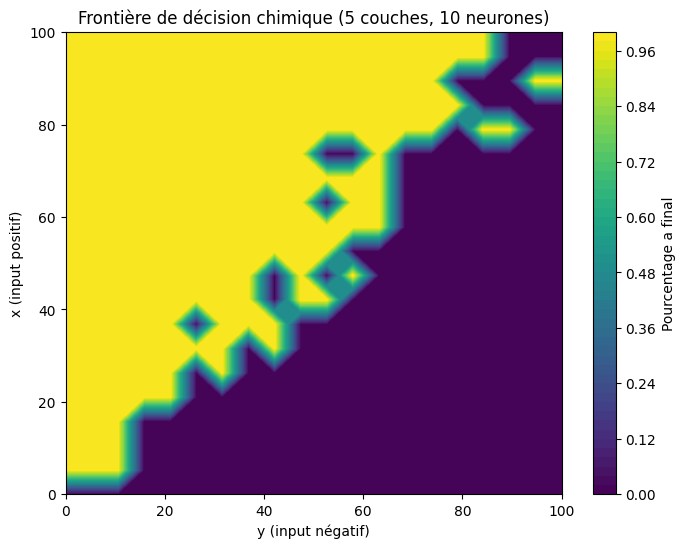

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# --- Global parameters for the chemical dynamics ---
lambda_a = 1.0
lambda_b = 1.0
ka = 0.5
kb = 0.5
eta_a = 0.1
eta_b = 0.1
mu_ab = 0.2

# --- Neuron (droplet) dynamics ---
def neuron_dynamics(t, y, x_in, y_in, w_p_x=1.0, w_p_y=1.0):
    a, b = y
    da_dt = w_p_x * x_in + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = w_p_y * y_in + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

# --- Simulate one layer ---
def simulate_layer(X_bulk_vec, Y_bulk_vec, n_neurons=10):
    X_bulk = np.sum(X_bulk_vec)
    Y_bulk = np.sum(Y_bulk_vec)
    lambda_total = (X_bulk + Y_bulk) / n_neurons

    # Probabilities
    r = X_bulk / (X_bulk + Y_bulk) if (X_bulk + Y_bulk) > 0 else 0.0
    p_vec = X_bulk_vec / X_bulk if X_bulk > 0 else np.zeros_like(X_bulk_vec)
    q_vec = Y_bulk_vec / Y_bulk if Y_bulk > 0 else np.zeros_like(Y_bulk_vec)

    a_outputs = []
    b_outputs = []

    for _ in range(n_neurons):
        # Sample total n
        n = np.random.poisson(lambda_total)

        # Sample m | n
        m = np.random.binomial(n, r) if n > 0 else 0

        # Sample x_vec | m
        if m > 0:
            x_vec = np.random.multinomial(m, p_vec)
        else:
            x_vec = np.zeros_like(X_bulk_vec)

        # Sample y_vec | n - m
        if (n - m) > 0:
            y_vec = np.random.multinomial(n - m, q_vec)
        else:
            y_vec = np.zeros_like(Y_bulk_vec)

        # Inputs are sums (or could use vector form if your dynamics cares)
        x_in = np.sum(x_vec)
        y_in = np.sum(y_vec)

        # Solve ODE
        y0 = [0.0, 0.0]
        sol = solve_ivp(neuron_dynamics, [0, 50], y0, args=(x_in, y_in), method='LSODA')
        a_final = sol.y[0, -1]
        b_final = sol.y[1, -1]

        a_outputs.append(a_final)
        b_outputs.append(b_final)

    # Return vector of aᶦ and bᶦ for this layer
    return np.array(a_outputs), np.array(b_outputs)

# --- Simulate multiple layers ---
def simulate_network(X_bulk_init, Y_bulk_init, n_layers=2, n_neurons=10):
    # Start with initial bulk distributed evenly across neurons
    X_vec = np.full(n_neurons, X_bulk_init / n_neurons)
    Y_vec = np.full(n_neurons, Y_bulk_init / n_neurons)

    for _ in range(n_layers):
        X_vec, Y_vec = simulate_layer(X_vec, Y_vec, n_neurons=n_neurons)

    return X_vec, Y_vec

# --- Plot decision boundary ---
n_layers = 5  # Example: try with different numbers of layers
n_neurons = 10

x_vals = np.linspace(0, 100, 20)
y_vals = np.linspace(0, 100, 20)
Y_grid, X_grid = np.meshgrid(y_vals, x_vals)
Z_grid = np.zeros_like(X_grid)

iterator = tqdm(range(X_grid.shape[0] * X_grid.shape[1]), desc="Simulation en cours")

for idx in iterator:
    i = idx // X_grid.shape[1]
    j = idx % X_grid.shape[1]

    X_input = X_grid[i, j]
    Y_input = Y_grid[i, j]

    a_vec, b_vec = simulate_network(X_input, Y_input, n_layers=n_layers, n_neurons=n_neurons)
    a_pooled = np.sum(a_vec)
    b_pooled = np.sum(b_vec)

    if (a_pooled + b_pooled) > 0:
        Z_grid[i, j] = a_pooled / (a_pooled + b_pooled)
    else:
        Z_grid[i, j] = 0.0

plt.figure(figsize=(8, 6))
cp = plt.contourf(Y_grid, X_grid, Z_grid, levels=50, cmap='viridis')
plt.colorbar(cp, label='Pourcentage a final')
plt.xlabel('y (input négatif)')
plt.ylabel('x (input positif)')
plt.title(f'Frontière de décision chimique ({n_layers} couches, {n_neurons} neurones)')
plt.show()



regarder la dépendance en lambda (papier gabin) lambda environ 1 regime particulier. regarder ce qu'il se passe quand lambda est de 1. \deltax = \delta a pour moi entre le debut et la fin du premier round. fraction de a après un round en fonction de lambda det on drevait voir 2 zones . comparer avec diagramme bulk si lambda>>>1 et tj meme chose alors cpt joue pas

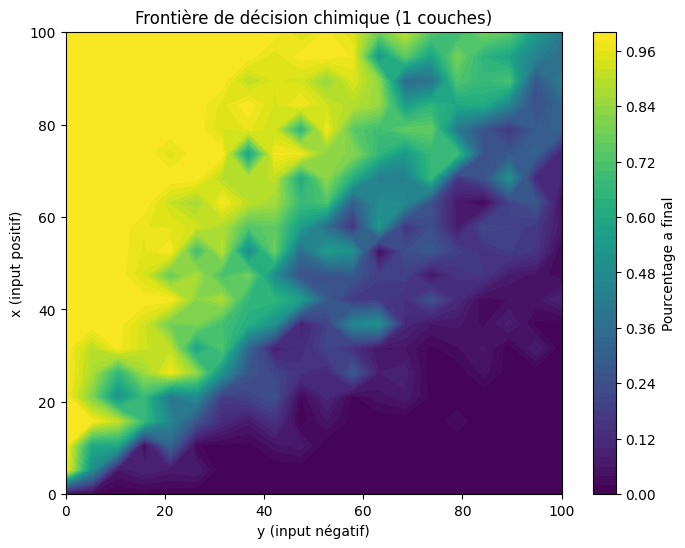